#Setting Up Data

Import all the necessary libraries needed to carry out the analysis.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import operator

Open the file with all the comments and data to create a dictionary. Here we use Pickle and PRAW (Python Reddit API Wrapper). 

In [2]:
%%time

import cPickle
import praw

threads = cPickle.load(open('all_comments_dict.p', 'rb'))
print "Number of AskReddit posts: %0.0f" % (len(threads))

Number of AskReddit posts: 100
Wall time: 39.1 s


We can see what type of attributes each comment has and an example of how many comments a post can have.

In [3]:
from pprint import pprint
pprint (vars(threads['2rb0pa'][0]))

{'_has_fetched': True,
 '_has_fetched_replies': True,
 '_info_url': u'https://api.reddit.com/api/info/',
 '_replies': [<praw.objects.Comment object at 0x0000000094042128>],
 '_submission': <praw.objects.Submission object at 0x0000000093EBCCF8>,
 '_underscore_names': [u'replies'],
 '_uniq': None,
 'approved_by': None,
 'archived': True,
 'author': Redditor(user_name='finndre'),
 'author_flair_css_class': None,
 'author_flair_text': None,
 'banned_by': None,
 'body': u'Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf',
 'body_html': u'<div class="md"><p>Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf</p>\n</div>',
 'controversiality': 0,
 'created': 1420430099.0,
 'created_utc': 1420401299.0,
 'distinguished': None,
 'downs': 0,
 'edited': False,
 'gilded': 0,
 'id': u'cnecm22',
 'json_dict': None,
 'likes': None,
 'link_id': u't3_2rb0pa',
 'mod_reports': [],
 'name': u't1_cnecm22',
 'num_repor

In [4]:
pprint (len(threads['2rb0pa']))

1575


Next, we make a dataframe from all the comments using only the most interesting fields that we believe can later be used for prediction or modeling.

In [5]:
fields = ['_replies',
          '_submission',
          'author',
          'author_flair_css_class',
          'author_flair_text',
          'banned_by',
          'body',
          'body_html',
          'controversiality',
          'created',
          'created_utc',
          'distinguished',
          'downs',
          'edited',
          'gilded',
          'score',
          'score_hidden',
          'subreddit',
          'ups'
         ]

dlist = []
for thread in threads: 
    for comment in threads[thread]:
        temp_d = {}
        temp_d['thread'] = thread
        for field in fields:
            temp_d[field] = comment.__dict__[field]
        dlist.append(temp_d)

df = pd.DataFrame(dlist)

In [6]:
df.head(5)

,_replies,_submission,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,created_utc,distinguished,downs,edited,gilded,score,score_hidden,subreddit,thread,ups
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,None,None,None,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,None,0,False,0,2485,False,AskReddit,36ih74,2485
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,None,None,None,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,None,0,False,1,4983,False,AskReddit,36ih74,4983
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,None,None,None,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,None,0,False,0,2386,False,AskReddit,36ih74,2386
3,"[That sounds painful., Some people just can't ...",4701 :: What is one sentence that people in yo...,cgrosshans,None,None,None,"""Move off that shallow pocket and greasy crimp...","<div class=""md""><p>&quot;Move off that shallow...",0,1432084937,1432056137,None,0,False,0,3197,False,AskReddit,36ih74,3197
4,[Sounds like a good roller disc. ],4701 :: What is one sentence that people in yo...,rottinguy,None,None,None,The disc is so understable I have to put a rid...,"<div class=""md""><p>The disc is so understable ...",0,1432086084,1432057284,None,0,False,0,1438,False,AskReddit,36ih74,1438


#Data Exploration

First let's find some useful information about comments in general, such as average comment length and standard deviation, average number of upvotes and standard deviation, etc. Let's begin with some basic information: 

In [8]:
print "Upvotes mean: %0.2f" % (np.mean(df['ups']))
print "Upvotes median: %0.2f" % (np.median(df['ups']))
print "Upvotes standard deviation: %0.2f" % (np.std(df['ups']))
print "------------------"
print "Gilded mean: %0.2f" % (np.mean(df['gilded']))
print "Gilded median: %0.2f" % (np.median(df['gilded']))
print "Gilded standard deviation: %0.2f" % (np.std(df['gilded']))

Upvotes mean: 80.88
Upvotes median: 2.00
Upvotes standard deviation: 498.15
------------------
Gilded mean: 0.01
Gilded median: 0.00
Gilded standard deviation: 0.11


Let's start by adding the character count for each comment to the dataframe and viewing some relevant statistics.

In [9]:
df['character_count'] = df['body'].map(lambda x : len(x))

In [10]:
print "Length mean: %0.2f" % (np.mean(df['character_count']))
print "Length median: %0.2f" % (np.median(df['character_count']))
print "Length standard deviation: %0.2f" % (np.std(df['character_count']))

Length mean: 196.79
Length median: 93.00
Length standard deviation: 346.24


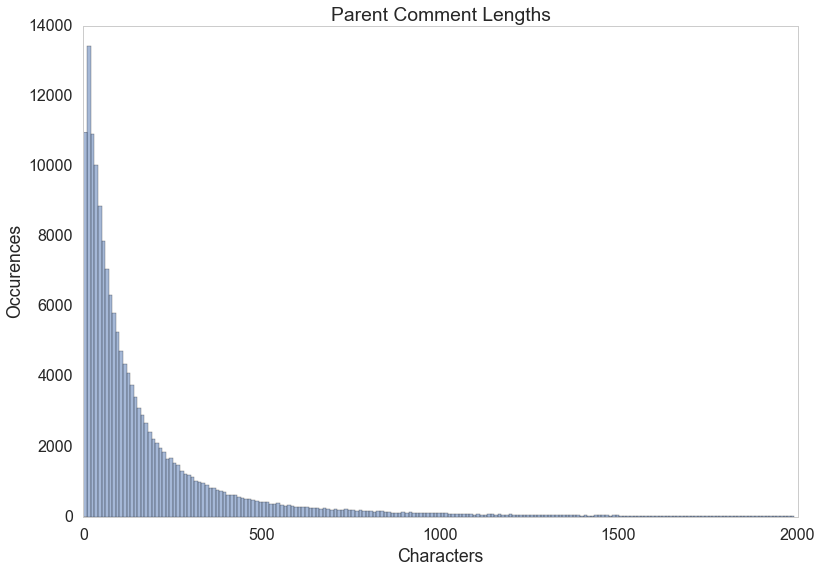

In [11]:
plt.hist(df['character_count'], bins=np.arange(1,2000,10), alpha=0.5, label="Character Lengths");
plt.title('Parent Comment Lengths');
plt.xlabel('Characters');
plt.ylabel('Occurences');
plt.grid(False);

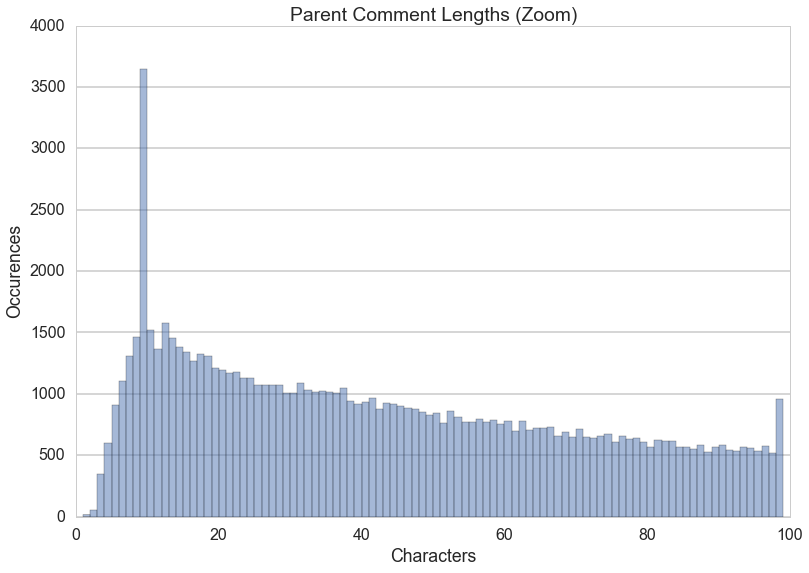

In [12]:
plt.hist(df['character_count'], bins=np.arange(1,100,1), alpha=0.5, label="Character Lengths");
plt.title('Parent Comment Lengths (Zoom)');
plt.xlabel('Characters');
plt.ylabel('Occurences');
ax = plt.gca()
ax.xaxis.grid(False) 

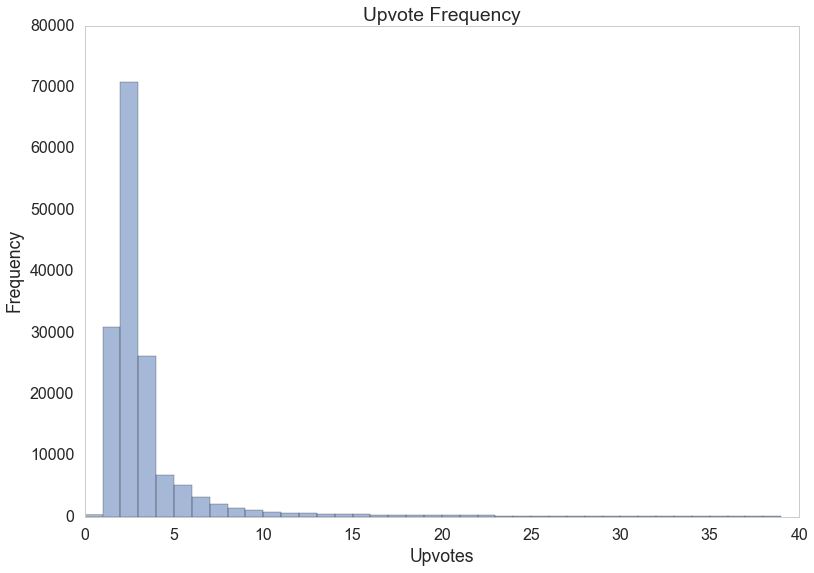

In [14]:
plt.hist(df['ups'], bins=np.arange(0,40,1), alpha=0.5, label="Upvotes");
plt.title('Upvote Frequency');
plt.xlabel('Upvotes');
plt.ylabel('Frequency');
plt.grid(False)

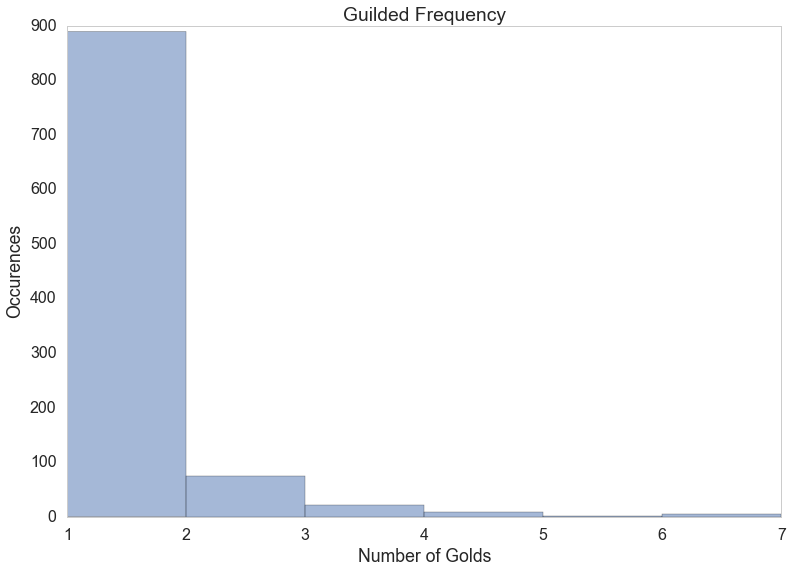

In [16]:
plt.hist(df['gilded'], bins=np.arange(1,8,1), alpha=0.5, label="Gilded");
plt.title('Guilded Frequency');
plt.xlabel('Number of Golds');
plt.ylabel('Occurences');
plt.grid(False)

#Correlations

##Time

First, we can look at the time that a comment is posted and see how that relates to its popularity.

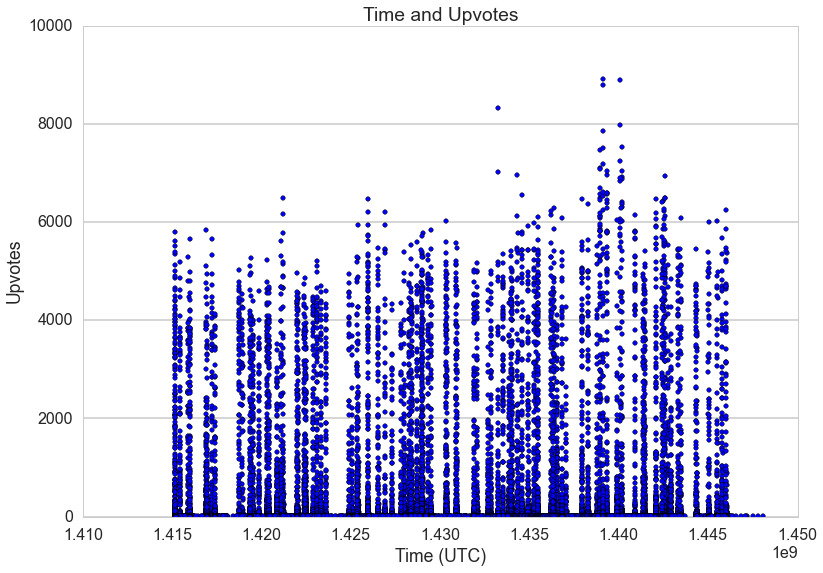

In [18]:
plt.scatter(df['created_utc'], df['ups']);
plt.title('Time and Upvotes');
plt.xlabel('Time (UTC)');
plt.ylabel('Upvotes');
plt.ylim(ymin=-0.1);
ax = plt.gca();
ax.xaxis.grid(False)

The pattern above is fairly interesting. Nearly all the highly upvoted comments appear in a very short span of time, which perhaps leads us to believe that an early comment is more likely to receive more upvotes. 

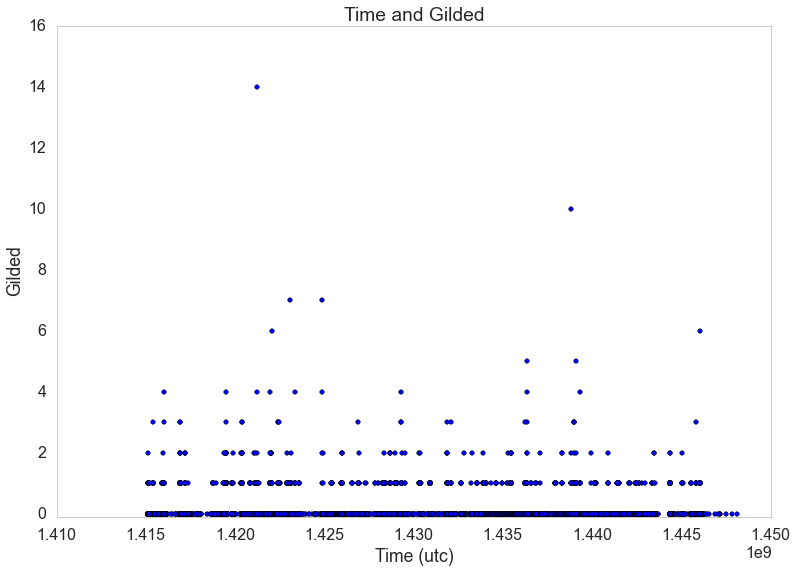

In [19]:
plt.scatter(df['created_utc'], df['gilded']);
plt.title('Time and Gilded');
plt.xlabel('Time (utc)');
plt.ylabel('Gilded');
plt.ylim(ymin=-0.1);
plt.grid(False);

So, let's take a closer look at how the **difference in time** between the initial post and the comment affects its popularity.

In [20]:
df['time_delay'] = df.apply(lambda row : row['created_utc'] - row['_submission'].created_utc, axis=1)

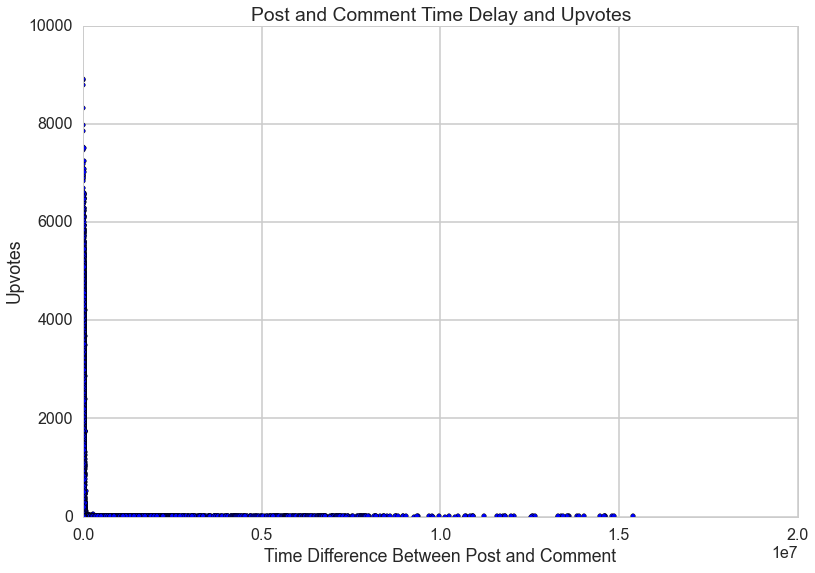

In [21]:
plt.scatter(df['time_delay'], df['ups']);
plt.title('Post and Comment Time Delay and Upvotes');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Upvotes');
plt.ylim(ymin=-0.5);
plt.xlim(xmin=-0.5);

Zooming in toward the quicker commenters reveals an interesting pattern below. 

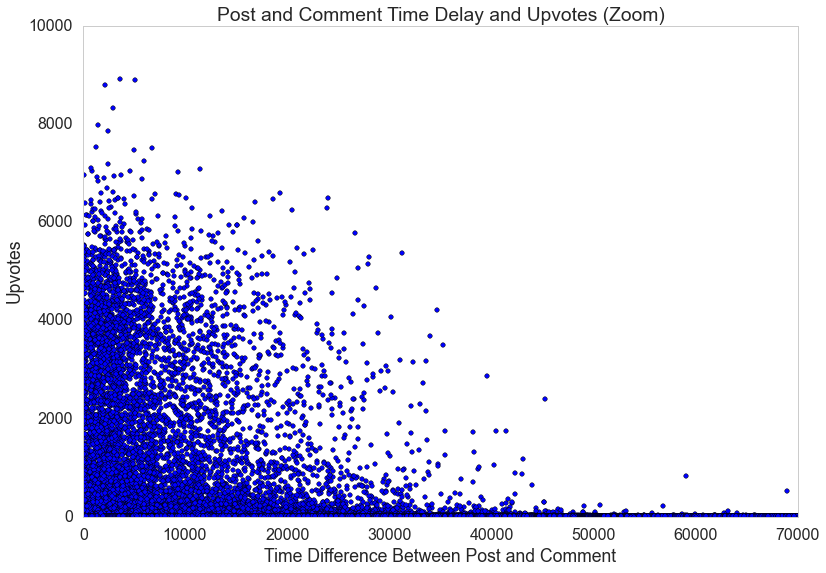

In [22]:
plt.scatter(df['time_delay'], df['ups']);
plt.xlim(0,70000);
plt.ylim(ymin=-0.5)
plt.title('Post and Comment Time Delay and Upvotes (Zoom)');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Upvotes');
plt.grid(False);

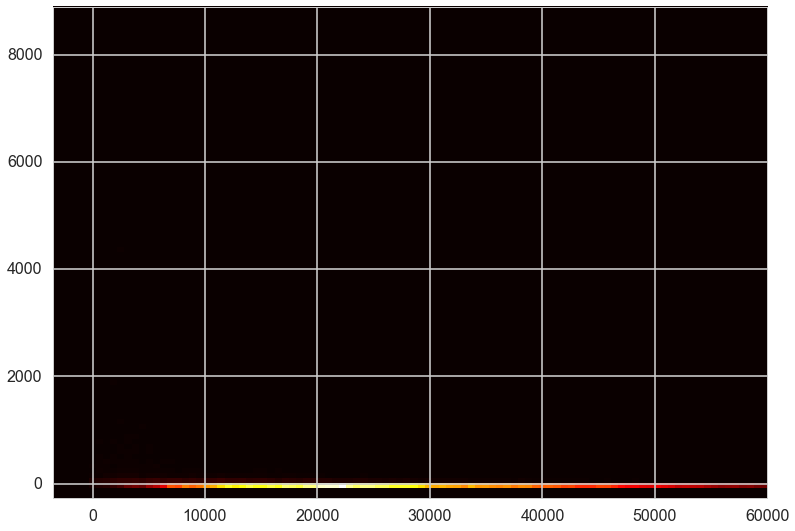

In [116]:
temp = df[(df.time_delay<60000)][['time_delay', 'ups']]
plt.hist2d(temp['time_delay'], temp['ups'], bins=100, cmap='hot');

A similar thing can be down for being gilded and quickness of commenting. 

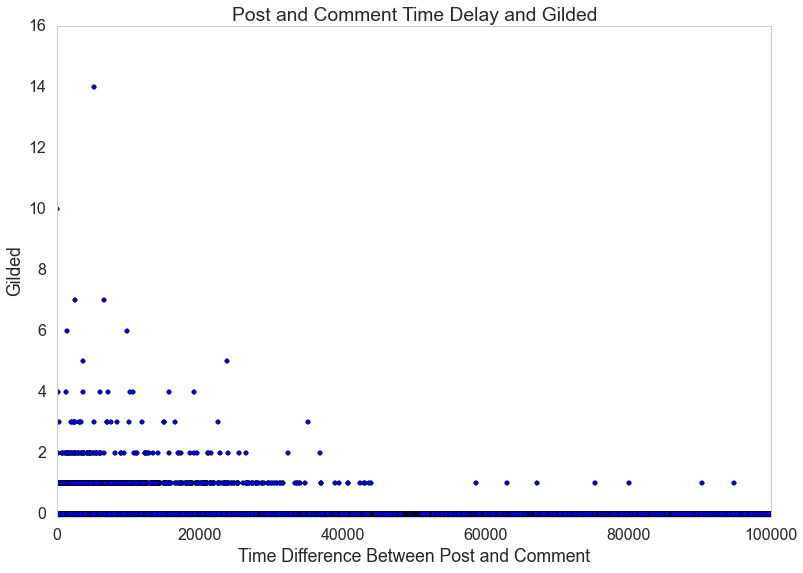

In [23]:
plt.scatter(df['time_delay'], df['gilded']);
plt.xlim(0,100000);
plt.ylim(ymin=-0.1);
plt.title('Post and Comment Time Delay and Gilded');
plt.xlabel('Time Difference Between Post and Comment');
plt.ylabel('Gilded');
plt.grid(False)

##Comment Content

###Characters

Next, we can look at the attributes of the body of the comment itself. Here is the **length of each comment** (number of characters) compared to its popularity: 

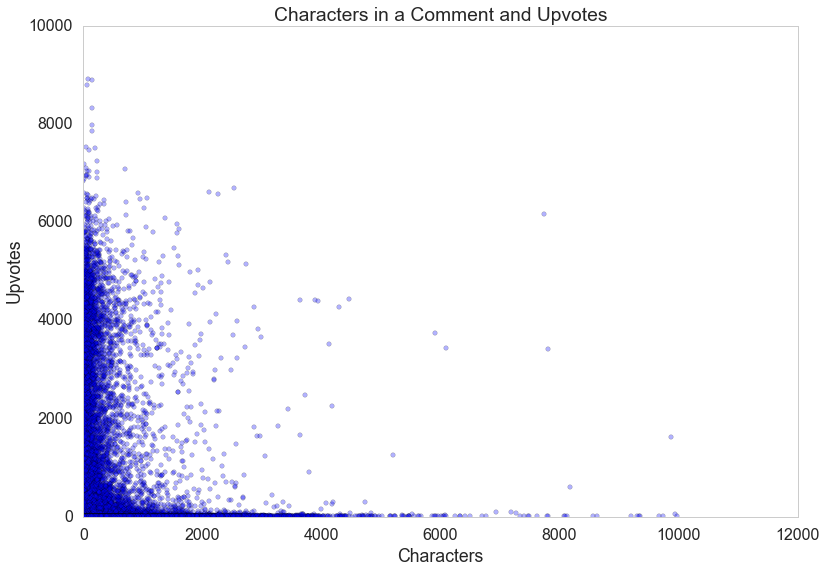

In [24]:
plt.scatter(df['character_count'], df['ups'], alpha=0.3);
plt.ylim(ymin=-0.1);
plt.xlim(xmin=-0.1);
plt.title('Characters in a Comment and Upvotes');
plt.xlabel('Characters');
plt.ylabel('Upvotes');
plt.grid(False)

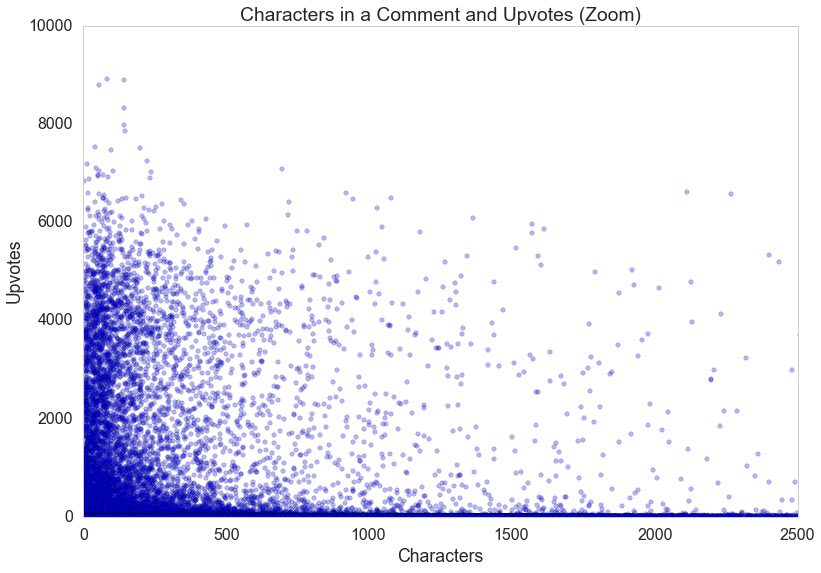

In [25]:
plt.scatter(df['character_count'], df['ups'], alpha=0.3);
plt.xlim(0,2500);
plt.ylim(ymin=-0.1);
plt.title('Characters in a Comment and Upvotes (Zoom)');
plt.xlabel('Characters');
plt.ylabel('Upvotes');
plt.grid(False)

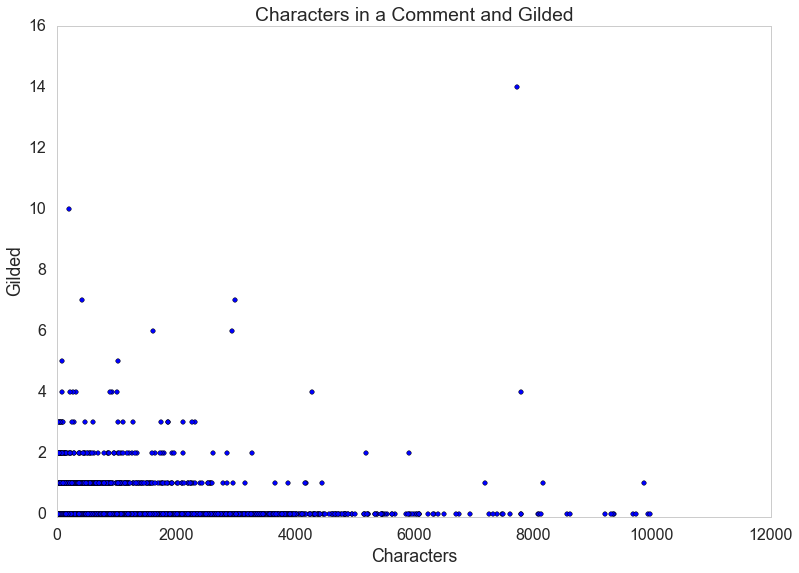

In [26]:
plt.scatter(df['character_count'], df['gilded']);
plt.ylim(ymin=-0.1);
plt.xlim(xmin=-0.1);
plt.title('Characters in a Comment and Gilded');
plt.xlabel('Characters');
plt.ylabel('Gilded');
plt.grid(False);

###Word Count

However, character count can only describe so much. Let's take a look at the word count: 

In [27]:
def word_count(text):
    wordList = re.sub("[^\w]", " ",  text).split()
    return len(wordList)

df['word_count'] = df['body'].map(lambda x : word_count(x))

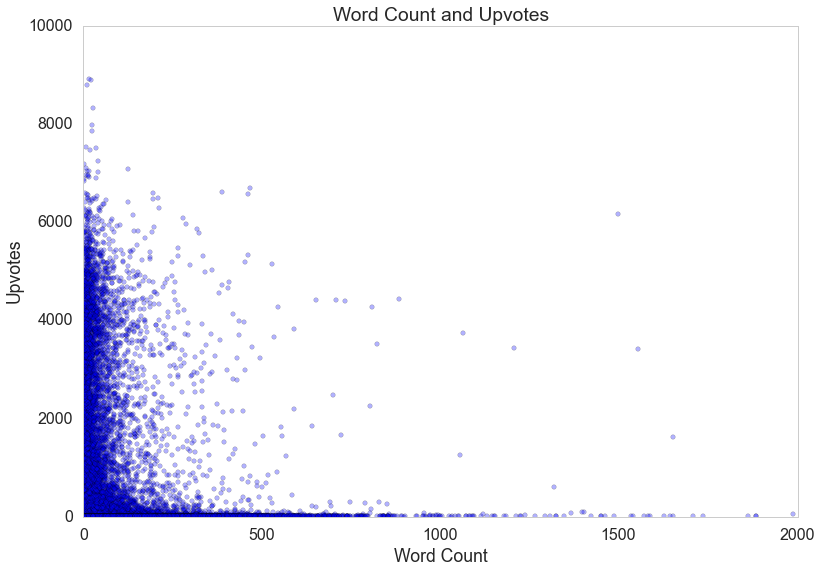

In [28]:
plt.scatter(df['word_count'], df['ups'], alpha=0.3);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Upvotes');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);
plt.grid(False)

Now we can also take a look at the average upvotes a comment will get if it has a certain number of words. 

In [96]:
# create dictionary of word count and upvotes
wcu = {}
wcg = {}
for thread in threads:
    for comment in threads[thread]:
        string = comment.body
        wordList = re.sub("[^\w]", " ",  string).split()
        length = len(wordList)
        if not length in wcu:
            wcu[length] = [comment.ups]
        else:
            wcu[length].append(comment.ups)
        if not length in wcg:
            wcg[length] = [comment.gilded]
        else:
            wcg[length].append(comment.gilded)

# create dictionary of word count and average upvotes
wcu_avg = {}
for key, value in wcu.iteritems():
    wcu_avg[key] = sum(value)/len(value)
    
wcg_avg = {}
for key, value in wcg.iteritems():
    wcg_avg[key] = sum(value)/len(value)
            
sxu = sorted(wcu_avg.items(), key=operator.itemgetter(1))
sxg = sorted(wcg_avg.items(), key=operator.itemgetter(1))

xsu = []
ysu = []
for pair in sxu:
    xsu.append(pair[0])
    ysu.append(pair[1])

xsg = []
ysg = []
for pair in sxg:
    xsg.append(pair[0])
    ysg.append(pair[1])


(-0.1, 7000.0)

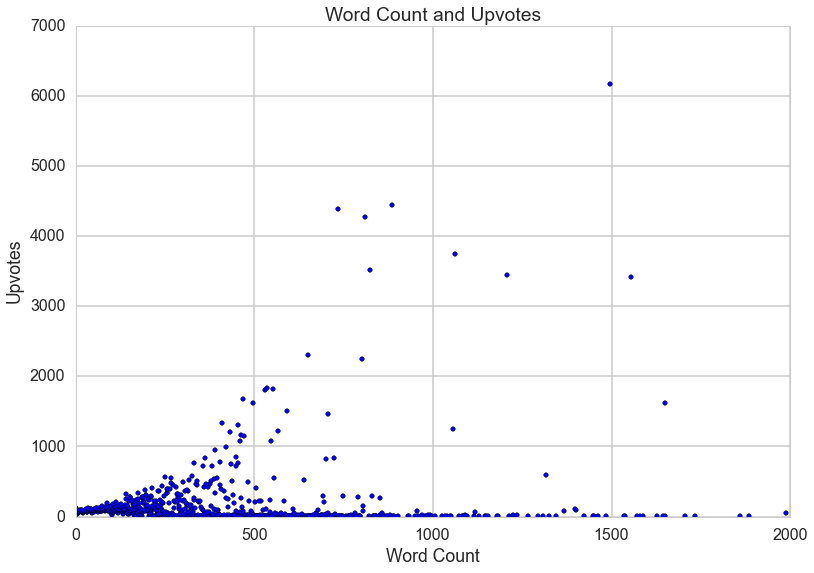

In [97]:
plt.scatter(xsu,ysu);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Average Upvotes');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);

We see some interesting behavior at low word counts where upvotes are fairly predictable. 

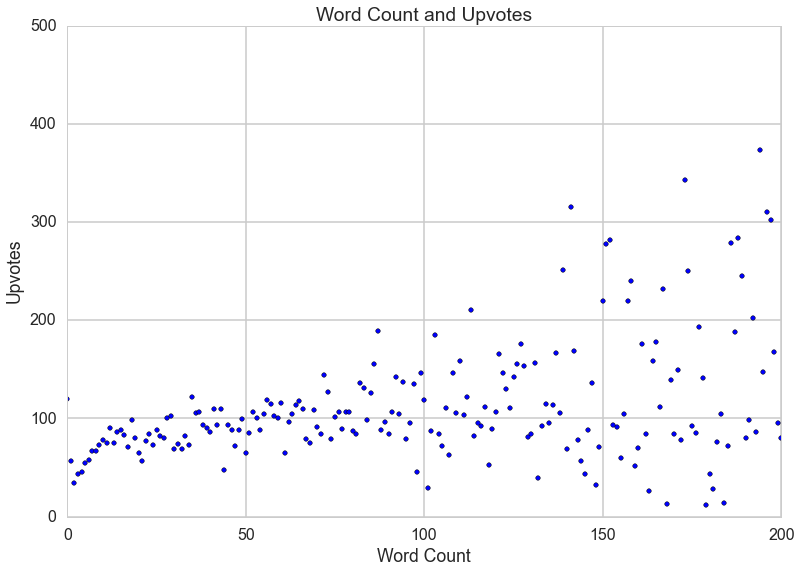

In [98]:
plt.scatter(xsu,ysu);
plt.title('Word Count and Upvotes');
plt.xlabel('Word Count');
plt.ylabel('Upvotes');
plt.xlim(-0.1,200);
plt.ylim(0, 500);

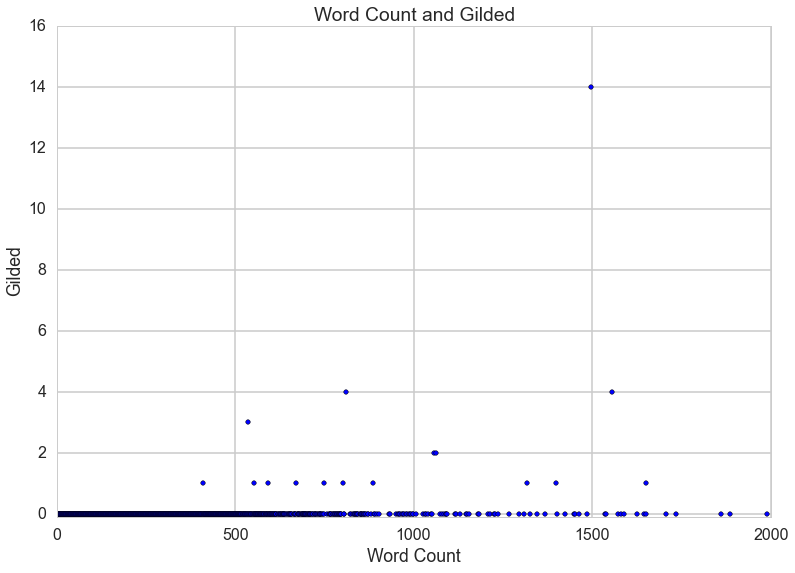

In [100]:
plt.scatter(xsg,ysg);
plt.title('Word Count and Gilded');
plt.xlabel('Word Count');
plt.ylabel('Gilded');
plt.xlim(-0.1,2000);
plt.ylim(ymin=-0.1);

###Word Choice - [Possibly cut this later]

Additionally, we can see what words are used in posts that have a lot of upvotes. Collect the vocabulary of all the comments in the post and the average upvotes in a comment associated with a word. 

In [64]:
# collect the words from comments and how many upvotes that comment got

wau = {}
for comment in threads['2rb0pa']:
    string = comment.body
    wordList = re.sub("[^\w]", " ",  string).split()
    for word in wordList: 
        if not word in wau:
            wau[word] = [comment.ups]
        else:
            wau[word].append(comment.ups)
            

In [65]:
# determine the average number of upvotes a comment with a certain word receives

wau_avg = {}
for key, value in wau.iteritems():
    wau_avg[key] = sum(value)/len(value)

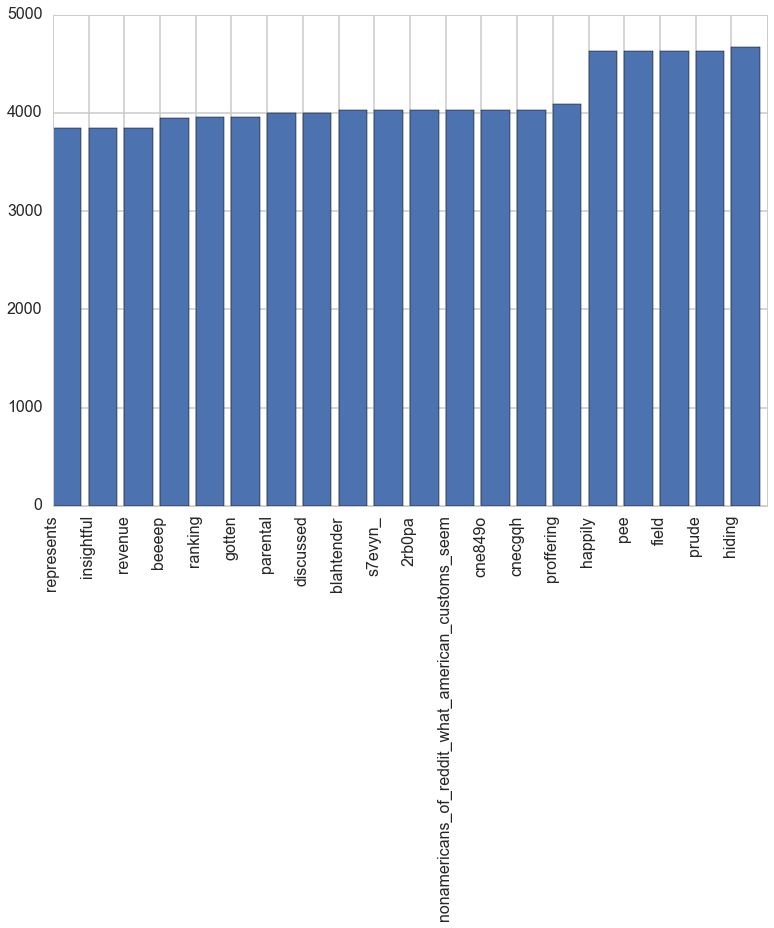

In [87]:
sx = sorted(wau_avg.items(), key=operator.itemgetter(1))

x = sx[-20:]
xs = []
ys = []

for pair in x:
    xs.append(pair[0])
    ys.append(pair[1])

plt.bar(range(len(xs)), ys);
plt.xticks(range(len(xs)), xs, rotation=90);


###Profanity

In [ ]:
# DO NOT RUN
# code that was used for cleaning the csv file 

sn = []
for swear in SWEARS:
    sn.append(swear[0:-3])
    
with open('profanity.csv', 'wb') as myfile:
    wr = csv.writer(myfile)
    for row in sn:
        wr.writerow([row])

Import a small dictionary of profanity.

In [29]:
import csv

input_file = csv.DictReader(open("profanity.csv"))

SWEARS = []
for row in input_file:
    SWEARS.append(row["swears"])
    

In [30]:
def swear_count(text):
    count = 0
    for swear in SWEARS:
        if swear in text:
            count = count + 1
    return count

df['swear_count'] = df['body'].map(lambda x : swear_count(x))

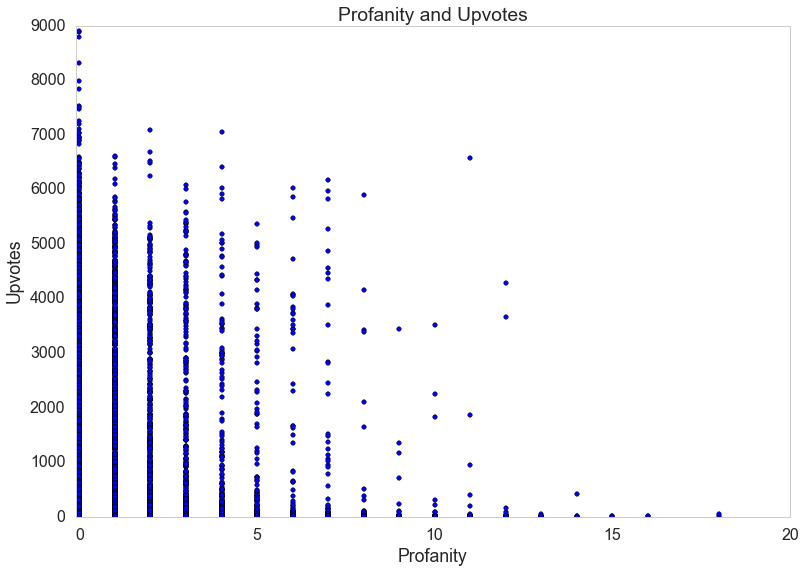

In [31]:
plt.scatter(df['swear_count'], df['ups']);
plt.title('Profanity and Upvotes');
plt.xlabel('Profanity');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);
plt.grid(False)

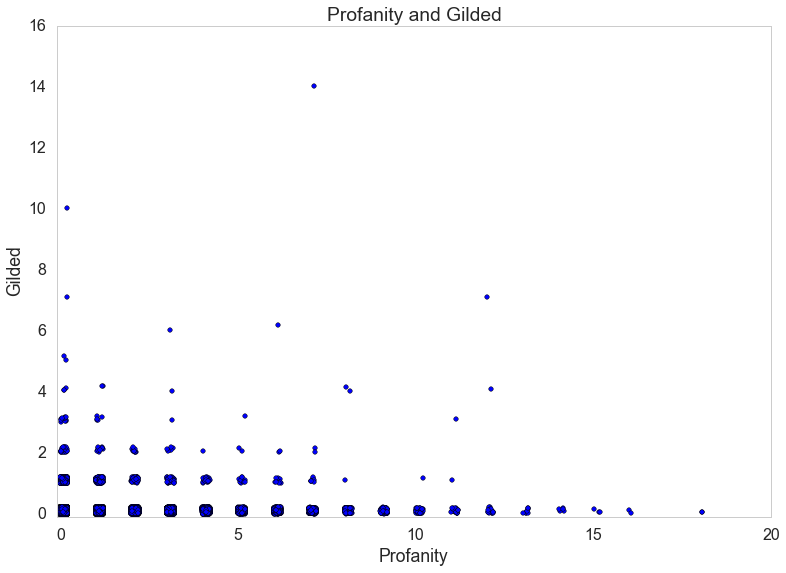

In [40]:
import random

# add some noise so that we can see density of points
noise1 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]
noise2 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]

plt.scatter(np.array(df['swear_count']) + np.array(noise1), np.array(df['gilded']) + np.array(noise2));
plt.title('Profanity and Gilded');
plt.xlabel('Profanity');
plt.ylabel('Gilded');
plt.xlim(-0.1,20);
plt.ylim(-0.1, 16);
plt.grid(False)

###Average Size of Words

In [41]:
def word_size(text):
    words = re.sub("[^\w]", " ",  text).split()
    if len(words) > 0: 
        avg = sum(len(word) for word in words)/len(words)
    else:
        return 0
    return avg

df['word_size'] = df['body'].map(lambda x : word_size(x))

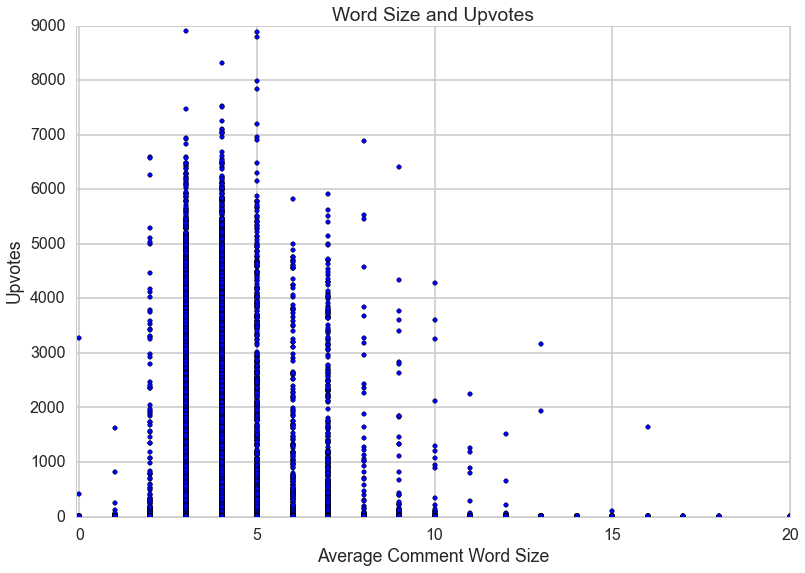

In [42]:
plt.scatter(df['word_size'], df['ups']);
plt.title('Word Size and Upvotes');
plt.xlabel('Average Comment Word Size');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);

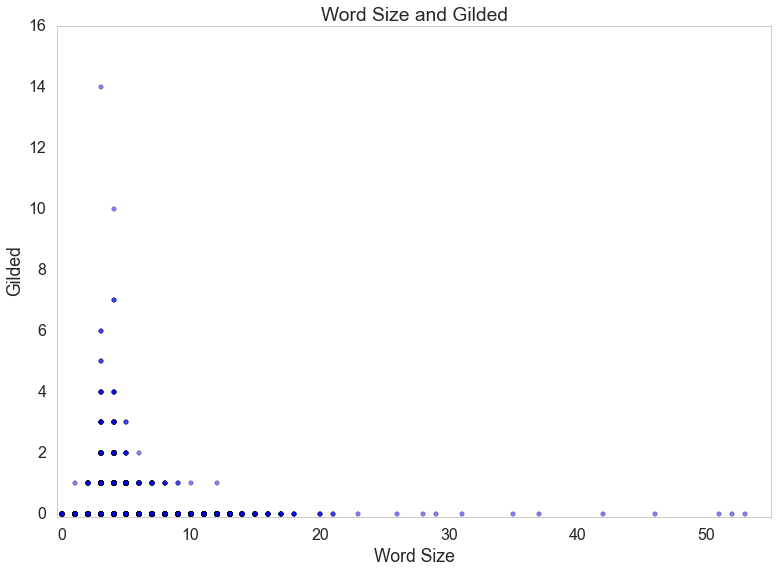

In [43]:
plt.scatter(df['word_size'], df['gilded'], alpha=0.5);
plt.title('Word Size and Gilded');
plt.xlabel('Word Size');
plt.ylabel('Gilded');
plt.xlim(-0.4,55);
plt.ylim(-0.1, 16);
plt.grid(False)

###Links to Outside Information

In [44]:
def link_count(html):
    urls = re.findall('<a href="?\'?([^"\'>]*)', html)
    count = len(urls)
    return count

df['link_count'] = df['body_html'].map(lambda x : link_count(x))

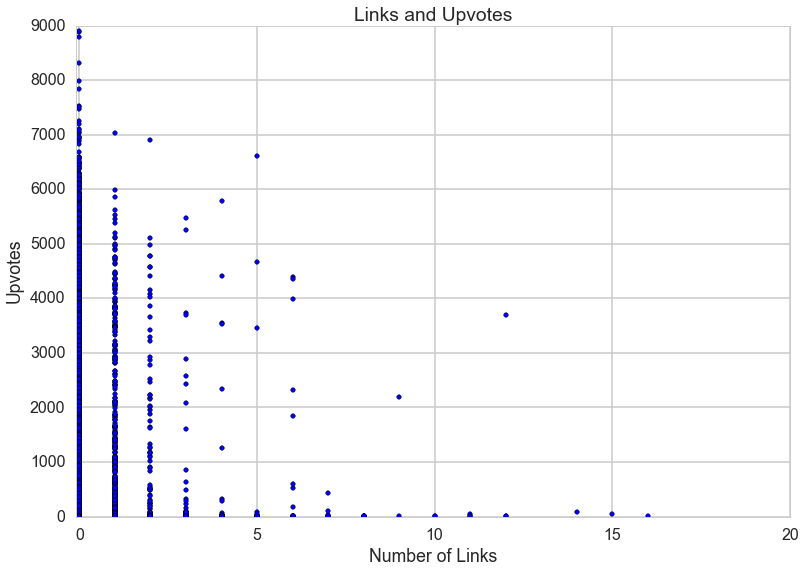

In [45]:
plt.scatter(df['link_count'], df['ups']);
plt.title('Links and Upvotes');
plt.xlabel('Number of Links');
plt.ylabel('Upvotes');
plt.xlim(-0.1,20);
plt.ylim(0, 9000);

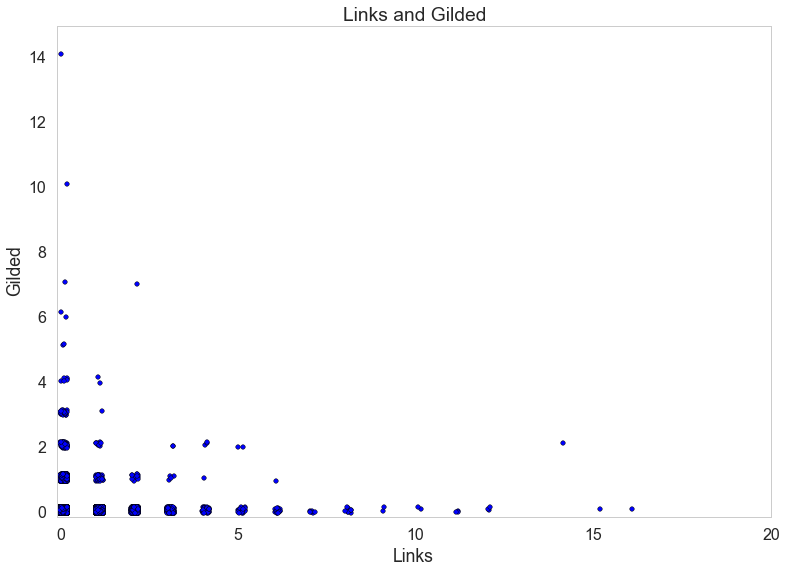

In [46]:
# add some noise so that we can see density of points
noise1 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]
noise2 = [round(random.uniform(0, 0.2), 5) for x in range(len(df['swear_count']))]

plt.scatter(np.array(df['link_count']) + np.array(noise1), np.array(df['gilded']) + np.array(noise2));
plt.title('Links and Gilded');
plt.xlabel('Links');
plt.ylabel('Gilded');
plt.xlim(-0.1,20);
plt.ylim(-0.1,15);
plt.grid(False)

###Markdown

In [47]:
# count times italics, bold, strikethrough, blockquote were used
def italics_count(html):
    italics = re.findall('<em>', html)
    count = len(italics)
    return count

def bold_count(html):
    bold = re.findall('<strong>', html)
    count = len(bold)
    return count

def st_count(html):
    st = re.findall('<s>', html)
    count = len(st)
    return count

def bq_count(html):
    bq = re.findall('<blockquote>', html)
    count = len(bq)
    return count

df['italics_count'] = df['body_html'].map(lambda x : italics_count(x))
df['bold_count'] = df['body_html'].map(lambda x : bold_count(x))
df['strikethrough_count'] = df['body_html'].map(lambda x : st_count(x))
df['blockquote_count'] = df['body_html'].map(lambda x : bq_count(x))

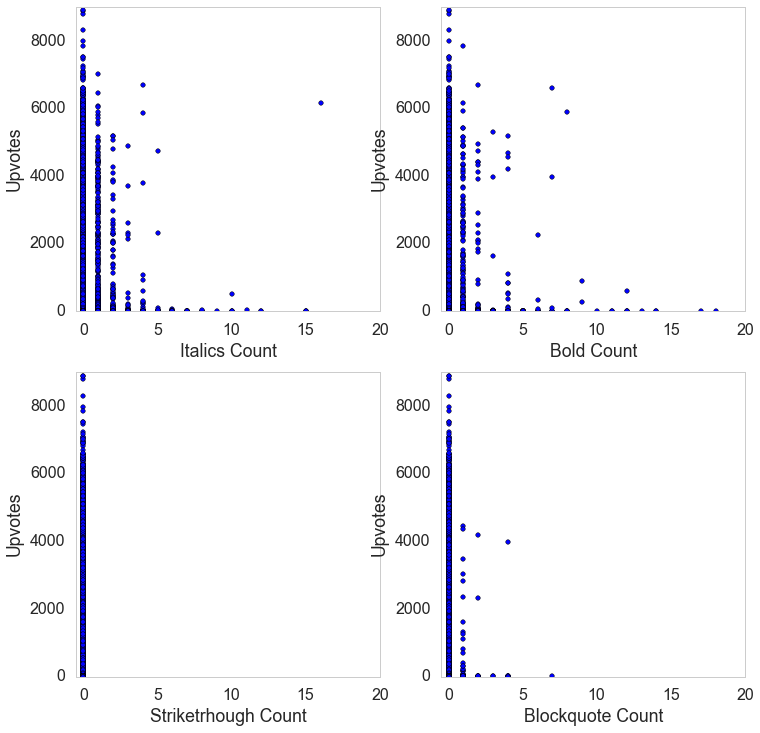

In [49]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

pcols = ['italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count']
names = ['Italics Count', 'Bold Count', 'Striketrhough Count', 'Blockquote Count']

for ax, pcol, name in zip(axes.ravel(), pcols, names):
    
    ax.scatter(df[pcol], df['ups']);
    ax.set_xlabel(name);
    ax.set_ylabel('Upvotes');
    ax.set_xlim(-0.5,20);
    ax.set_ylim(-0.5, 9000);
    ax.grid(False);

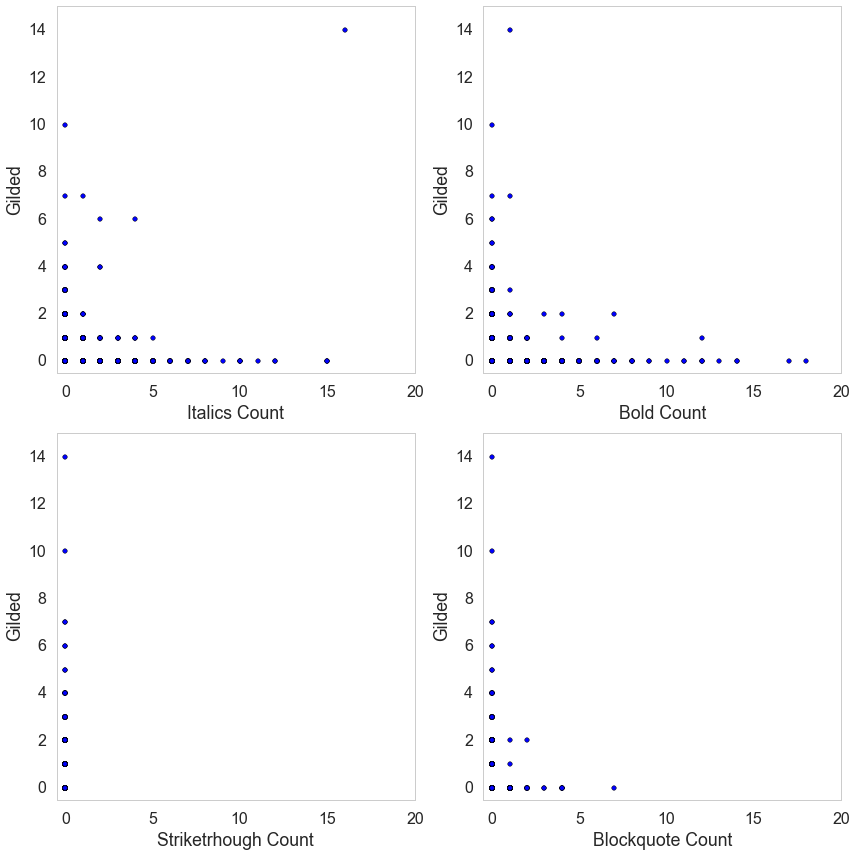

In [50]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), tight_layout=True)

pcols = ['italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count']
names = ['Italics Count', 'Bold Count', 'Striketrhough Count', 'Blockquote Count']

for ax, pcol, name in zip(axes.ravel(), pcols, names):
    
    ax.scatter(df[pcol], df['gilded']);
    ax.set_xlabel(name);
    ax.set_ylabel('Gilded');
    ax.set_xlim(-0.5,20);
    ax.set_ylim(-0.5, 15);
    ax.grid(False)

###Paragraph Count

In [51]:
def p_count(html):
    ps = re.findall('<p>', html)
    count = len(ps)
    return count

df['paragraph_count'] = df['body_html'].map(lambda x : p_count(x))

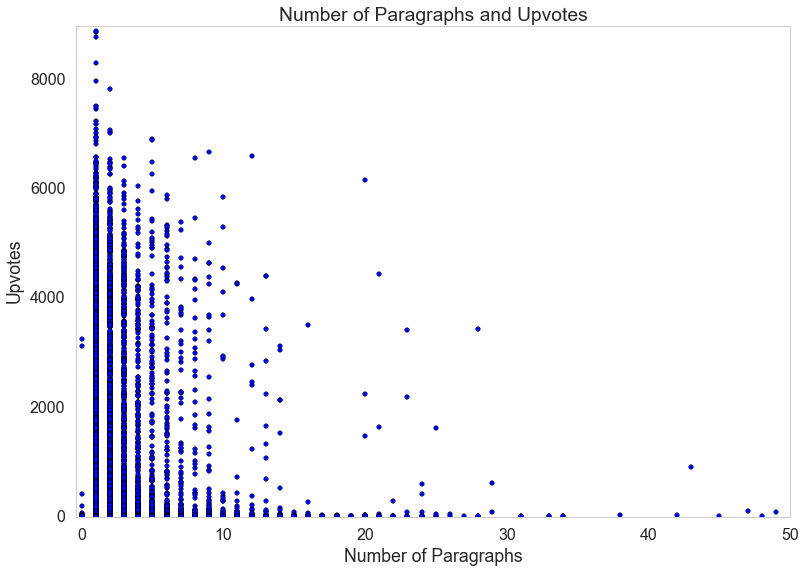

In [52]:
plt.scatter(df['paragraph_count'], df['ups']);
plt.title('Number of Paragraphs and Upvotes');
plt.xlabel('Number of Paragraphs');
plt.ylabel('Upvotes');
plt.xlim(-0.4,50);
plt.ylim(-0.5,9000);
plt.grid(False)

(-1000, 4000)

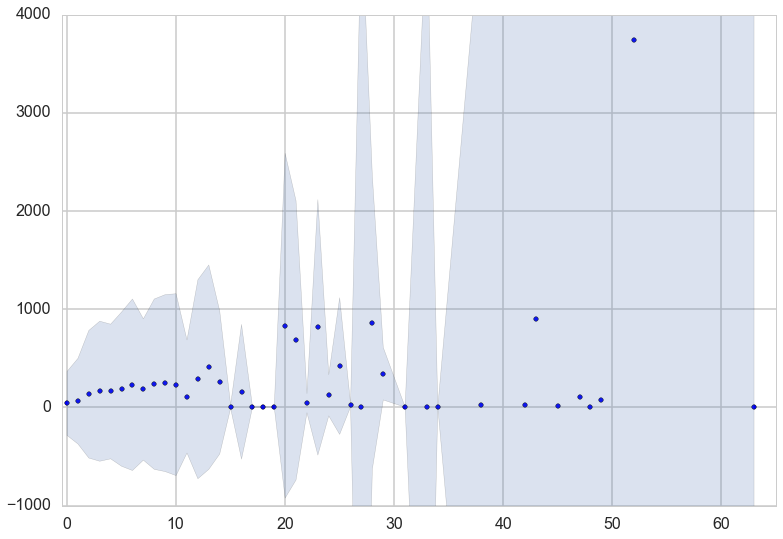

In [73]:
# just a test plot to see standard deviation alongside averages

pl = sorted(df.paragraph_count.unique())
means = []
stds = []

for i in pl:
    temp = df[(df.paragraph_count==i)][['ups']]
    means.append(np.mean(temp['ups']))
    std = np.std(temp['ups'])
    if std == 0: 
        stds.append(5000)
    else: 
        stds.append(std)
    
plt.scatter(pl, means)
plt.fill_between(pl, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)
plt.xlim(-0.5, 65)
plt.ylim(-1000,4000)

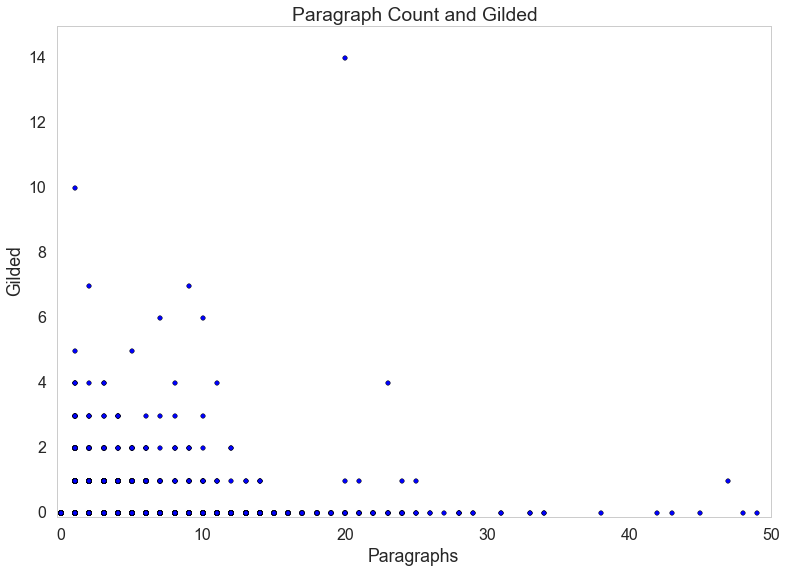

In [53]:
plt.scatter(df['paragraph_count'], df['gilded']);
plt.title('Paragraph Count and Gilded');
plt.xlabel('Paragraphs');
plt.ylabel('Gilded');
plt.xlim(-0.3,50);
plt.ylim(-0.1, 15);
plt.grid(False)

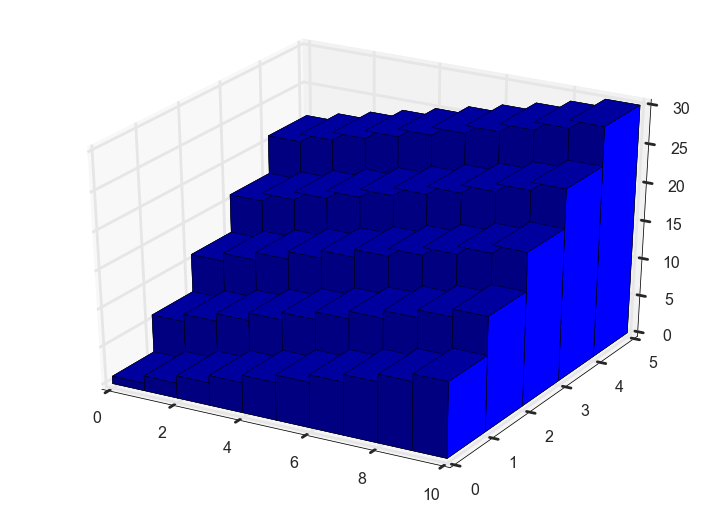

In [143]:
# IGNORE - just testing how to do a 3D plot

from mpl_toolkits.mplot3d import Axes3D

# Assuming you have "2D" dataset like the following that you need
# to plot.
#
data_2d = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            [11, 12, 13, 14, 15, 16, 17, 18 , 19, 20],
            [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
            [21, 22, 23, 24, 25, 26, 27, 28, 29, 30] ]
#
# Convert it into an numpy array.
#
data_array = np.array(data_2d)
#
# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#
x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )
#
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          1, 1, z_data )
#
# Finally, display the plot.
#
plt.show()

In [ ]:
'( ͡° ͜ʖ ͡°)'

Let's finish building the dataframe by turning certain variables into indicator variables.

In [72]:
df['i_author_flair_css_class']=(df.author_flair_css_class.notnull())*1
del df['author_flair_css_class']
df['i_author_flair_text']=(df.author_flair_text.notnull())*1
del df['author_flair_text']
df['i_distinguished']=(df.distinguished.notnull())*1
del df['distinguished']
df['i_edited']=(df.edited)*1
del df['edited']
df['i_score_hidden']=(df.score_hidden)*1
del df['score_hidden']
df['i_banned_by']=(df.banned_by.notnull())*1
del df['banned_by']

In [75]:
df.head(3)

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,i_edited,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_score_hidden,i_banned_by
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,0,0,2485,AskReddit,36ih74,2485,60,7011,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,0,1,4983,AskReddit,36ih74,4983,63,3024,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,0,0,2386,AskReddit,36ih74,2386,46,6330,10,0,3,0,0,0,0,0,1,0,0,0,0,0,0


Features:

* Character count [DONE]
* Word count [DONE]
* Time created [DONE]
* Time delay [DONE]
* Swear words [DONE]
* Average size of words [DONE]
* links included in comment [DONE]
* Markdown used [DONE]
* Paragraph count [DONE]
* Author username [DONE]
* Sentiment analysis [DONE]
* Relevance in vocabulary to original post [DONE]

##Prediction

###Baseline

Begin by standardizing the parts of the data that are integers or floats

In [76]:
dftouse=df.copy()

In [78]:
STANDARDIZABLE = ['created', 'created_utc', 'character_count', 'time_delay', 'word_count', 'swear_count',
                 'word_size', 'link_count', 'italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count',
                 'paragraph_count' 
                 ]

Create the training and testing sets.

In [10]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [ ]:
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=df[col].values[mask]
    valstest=df[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

First, let's build a baseline where we simply guess the number of upvotes a post will get by guessing using the mean and the median of the test set. 

In [17]:
def baseline(indf, mask):
    X = indf['ups']
    if mask !=None:
        Xtrain, Xtest = X[mask], X[~mask]

    mean = np.mean(Xtrain)
    median = np.median(Xtrain)
    
    training_error_mean = abs(Xtrain - mean)
    training_error_median = abs(Xtrain - median)
    
    test_error_mean = abs(Xtest - mean)
    test_error_median = abs(Xtest - median)
    
    training_accuracy1 = np.mean(training_error_mean)
    training_accuracy2 = np.mean(training_error_median)
    test_accuracy1 = np.mean(test_error_mean)
    test_accuracy2 = np.mean(test_error_median)
    
    print "############# Baseline Accuracy ########################"
    print "Accuracy on training data using mean:   %0.2f" % (training_accuracy1)
    print "Accuracy on training data using median: %0.2f" % (training_accuracy2)
    print "Accuracy on test data using mean:       %0.2f" % (test_accuracy1)
    print "Accuracy on test data using median:     %0.2f" % (test_accuracy2)
    print "########################################################"

In [18]:
baseline(dftouse, mask)

############# Baseline Accuracy ################
Accuracy on training data using mean:   147.64
Accuracy on training data using median: 79.65
Accuracy on test data using mean:       146.49
Accuracy on test data using median:     78.44
########################################################


C:\Program Files\Anaconda\envs\python2\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


###Logistic Regression with Lasso

Note the columns that we want to use to classify in the regression.

In [80]:
cols = ['created_utc',
        'time_delay',
        'word_count',
        'character_count',
        'word_count',
        'swear_count',
        'word_size',
        'link_count',
        'italics_count',
        'bold_count',
        'strikethrough_count',
        'blockquote_count',
        'paragraph_count'
        ]

In [81]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

Function to handle the regression.

In [82]:
from sklearn.metrics import confusion_matrix

def classify(clf, parameters, indf, featurenames, targetname, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    # print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest, temp

Run the regression.

In [83]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time

clflog,Xtrain,ytrain,Xtest,ytest  = classify(LogisticRegression(penalty="l1"),
                              {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, 
                              dftouse, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error'
                              )

reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

----------------------------------------------------

Using a smaller df to run tests of the code

In [102]:
minidf = dftouse[0:10000]

In [103]:
from sklearn.cross_validation import train_test_split
itrain2, itest2 = train_test_split(xrange(minidf.shape[0]), train_size=0.7)

mask2=np.ones(minidf.shape[0], dtype='int')
mask2[itrain2]=1
mask2[itest2]=0
mask2 = (mask2==1)

In [104]:
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=df[col].values[mask2]
    valstest=df[col].values[~mask2]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask2.shape[0])
    out[mask2]=outtrain
    out[~mask2]=outtest
    minidf[col]=out

created
created_utc
character_count
time_delay
word_count
swear_count
word_size
link_count
italics_count
bold_count
strikethrough_count
blockquote_count
paragraph_count


C:\Program Files\Anaconda\envs\python2\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
%%time

clflog, Xtrain, ytrain, Xtest, ytest, temp  = classify(
                              LogisticRegression(penalty="l1"),
                              {"C": [1.0]}, 
                              minidf, 
                              cols,
                              'ups',
                              mask = mask2,
                              score_func = 'r2',
                              n_folds = 5
                              )

reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

mask
BEST {'C': 1.0} -28.0910444061 [mean: -28.09104, std: 48.92012, params: {'C': 1.0}]
############# based on standard predict ################
Accuracy on training data: 0.54
Accuracy on test data:     0.56
########################################################
Wall time: 27 s


C:\Program Files\Anaconda\envs\python2\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [106]:
temp = abs(clflog.predict(Xtest) - ytest)

In [107]:
print(sum(temp)/len(temp))

74
